# Epicurious Data Analysis

**Autor:** Raphael Brito Alencar

**Descrição:** Análise dos dados coletados do site https://www.epicurious.com/

In [63]:
# carregando libs
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import iqr, norm, probplot

import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
from nltk import pos_tag, word_tokenize
import re

import json
import gc

%matplotlib inline

[nltk_data] Downloading package punkt to /home/raphael-b-
[nltk_data]     alencar/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/raphael-b-alencar/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [64]:
# Utils
# percentual de preenchimento de cada feature
def show_filling_factor(data):
    missing_df = data.isnull().sum(axis=0).reset_index()
    missing_df.columns = ['variable', 'missing values']
    missing_df['filling factor (%)'] = ((data.shape[0] - missing_df['missing values']) / data.shape[0]) * 100
    return missing_df.sort_values('filling factor (%)').reset_index(drop = True)

# histograma e normal probability plot
def create_hist_prob_plot(ser):
    sns.distplot(ser, fit=norm);
    fig = plt.figure()
    res = probplot(ser, plot=plt)
    
# transformar para log
def log_transform(ser):
    return ser.map(lambda i: np.log(i) if i > 0 else 0)

def fillna_outlier_median(col):
    # substituindo valores de outliers e valores faltantes pela mediana 
    IQR = iqr(data[col], nan_policy='omit')
    upper_bound = data[col].quantile(0.75) + 1.5 * IQR
    lower_bound = data[col].quantile(0.25) - 1.5 * IQR
    
    outliers = data[(data[col] > upper_bound) | (data[col] < lower_bound)]
    outliers_idx = outliers.index
    
    median = data[~data.isin(outliers)][col].median()
    
    data.loc[outliers_idx, col] = median
    data[col].fillna(median, inplace=True)
    
    return data[col].describe().round(decimals=2).drop('count')

def skew_kurt(col):
    # skewness e kurtosis
    print("Skewness: %f" % data[col].skew())
    print("Kurtosis: %f" % data[col].kurt())

def count_sublist_values(data,sublist):
    series = list()
    for i in data.index:
        try:
            t = data.loc[i, sublist]
            for j in t:
                series.append(j)
        except:
            pass
    return pd.Series(series)

def sublist_uniques(data,sublist):
    categories = set()
    for i in data.index:
        try:
            t = data.loc[i, sublist]
            for j in t:
                categories.add(j)
        except:
            pass
    return list(categories)

def sublists_to_binaries(data, sublist, index_key = None):
    categories = sublist_uniques(data,sublist)
    frame = pd.DataFrame(columns=categories)
    for i in data.index:
        if type(data.loc[i, sublist]) == list or np.array:
            try:
                if index_key != None:
                    key = data.loc[i, index_key]
                    f = np.zeros(len(categories))
                    for j in data.loc[i, sublist]:
                        f[categories.index(j)] = 1
                    if key in frame.index:
                        for j in data.loc[i, sublist]:
                            frame.loc[key][j]+=1
                    else:
                        frame.loc[key]=f
                else:
                    f = np.zeros(len(categories))
                    for j in data.loc[i, sublist]:
                        f[categories.index(j)] = 1
                    frame.loc[i]=f
            except:
                pass
                
    return frame

In [65]:
# carregando dados de receitas.json
# verificando os primeiros registros
data = pd.read_json('receitas.json')
data.head()

,directions,fat,date,categories,calories,desc,protein,rating,title,ingredients,sodium
0,"[1. Place the stock, lentils, celery, carrot, ...",7.0,2006-09-01 04:00:00+00:00,"[Sandwich, Bean, Fruit, Tomato, turkey, Vegeta...",426.0,None,30.0,2.500,"Lentil, Apple, and Turkey Wrap","[4 cups low-sodium vegetable or chicken stock,...",559.0
1,[Combine first 9 ingredients in heavy medium s...,23.0,2004-08-20 04:00:00+00:00,"[Food Processor, Onion, Pork, Bake, Bastille D...",403.0,This uses the same ingredients found in boudin...,18.0,4.375,Boudin Blanc Terrine with Red Onion Confit,"[1 1/2 cups whipping cream, 2 medium onions, c...",1439.0
2,[In a large heavy saucepan cook diced fennel a...,7.0,2004-08-20 04:00:00+00:00,"[Soup/Stew, Dairy, Potato, Vegetable, Fennel, ...",165.0,None,6.0,3.750,Potato and Fennel Soup Hodge,"[1 fennel bulb (sometimes called anise), stalk...",165.0
3,[Heat oil in heavy large skillet over medium-h...,NaN,2009-03-27 04:00:00+00:00,"[Fish, Olive, Tomato, Sauté, Low Fat, Low Cal,...",NaN,The Sicilian-style tomato sauce has tons of Me...,NaN,5.000,Mahi-Mahi in Tomato Olive Sauce,"[2 tablespoons extra-virgin olive oil, 1 cup c...",NaN
4,[Preheat oven to 350°F. Lightly grease 8x8x2-i...,32.0,2004-08-20 04:00:00+00:00,"[Cheese, Dairy, Pasta, Vegetable, Side, Bake, ...",547.0,None,20.0,3.125,Spinach Noodle Casserole,"[1 12-ounce package frozen spinach soufflé, th...",452.0


In [66]:
data.shape

(20130, 11)

In [67]:
# informações sobre as colunas do dataframe
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20130 entries, 0 to 20129
Data columns (total 11 columns):
directions     20111 non-null object
fat            15908 non-null float64
date           20111 non-null datetime64[ns, UTC]
categories     20111 non-null object
calories       15976 non-null float64
desc           13495 non-null object
protein        15929 non-null float64
rating         20100 non-null float64
title          20111 non-null object
ingredients    20111 non-null object
sodium         15974 non-null float64
dtypes: datetime64[ns, UTC](1), float64(5), object(5)
memory usage: 1.7+ MB


In [68]:
# descrevendo estatísticas dos valores numéricos
# resultado sem dados tratados
data.describe().round(decimals=2)

,fat,calories,protein,rating,sodium
count,15908.00,15976.00,15929.00,20100.00,15974.00
mean,346.10,6307.86,99.95,3.71,6211.47
std,20431.02,358585.12,3835.62,1.34,332890.25
min,0.00,0.00,0.00,0.00,0.00
25%,7.00,198.00,3.00,3.75,80.00
50%,17.00,331.00,8.00,4.38,294.00
75%,33.00,586.00,27.00,4.38,711.00
max,1722763.00,30111218.00,236489.00,5.00,27675110.00


Alguns fatos observados na descrição estatística das features:
* Temos valores extremos para fat, calories, protein e sodium
* Um alto numero de ratings 4.38, o que parece um erro

In [69]:
# verificando registros duplicados
print('Número de receitas duplicadas: {}'.format(data.duplicated('title').sum()))

Número de receitas duplicadas: 2354


In [70]:
# removendo registros duplicados
data.drop_duplicates('title', keep='first', inplace=True)
data.shape

(17776, 11)

In [71]:
show_filling_factor(data)

,variable,missing values,filling factor (%)
0,desc,5859,67.039829
1,fat,3732,79.005401
2,protein,3713,79.112286
3,sodium,3689,79.247300
4,calories,3688,79.252925
5,rating,10,99.943744
6,directions,1,99.994374
7,date,1,99.994374
8,categories,1,99.994374
9,title,1,99.994374


Olhando a tabela acima, parece que os registros nulos são os mesmos para categories, date, directions, ingredients e title. No caso, 1 registro. Verificando:

In [72]:
# tratando valores nulos
data[data['categories'].isna()]

,directions,fat,date,categories,calories,desc,protein,rating,title,ingredients,sodium
1076,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [73]:
# excluindo registros totalmente nulos
data.drop(data[data['categories'].isna()].index, inplace=True)

show_filling_factor(data)

,variable,missing values,filling factor (%)
0,desc,5858,67.043601
1,fat,3731,79.009845
2,protein,3712,79.116737
3,sodium,3688,79.251758
4,calories,3687,79.257384
5,rating,9,99.949367
6,directions,0,100.000000
7,date,0,100.000000
8,categories,0,100.000000
9,title,0,100.000000


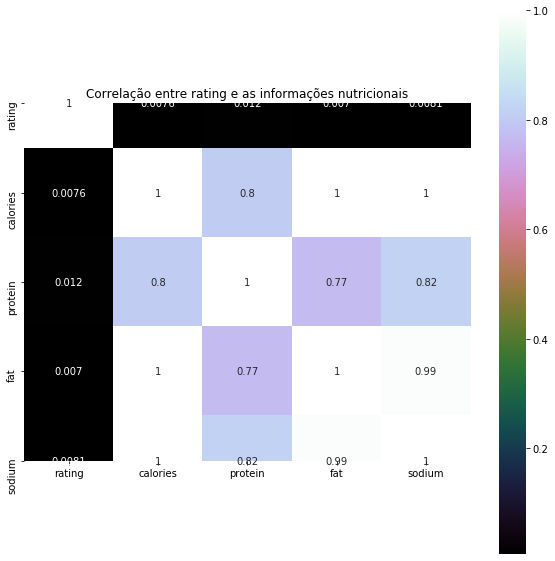

In [74]:
# verificando correlação entre variaveis numericas
cols = ['rating', 'calories', 'protein', 'fat', 'sodium']

plt.figure(figsize=(10,10))
sns.heatmap(data[cols].corr(), vmax=1, square=True,annot=True,cmap='cubehelix')
plt.title('Correlação entre rating e as informações nutricionais')
plt.show()

As variáveis nutricionais se correlacionam de forma positiva de acordo com o coeficiente de Pearson mostrado no heatmap acima. Fica claro, também, que ás variáveis **sodium** e **calories** são as que se correlacionam melhor com a variável **rating**.

Vamos analisar cada variável separadamente para tirarmos algumas conclusões:

### rating

In [75]:
data['rating'].describe().round(decimals=2).drop('count')

mean    3.72
std     1.32
min     0.00
25%     3.75
50%     4.38
75%     4.38
max     5.00
Name: rating, dtype: float64

In [76]:
data[data['rating'].isna()]

,directions,fat,date,categories,calories,desc,protein,rating,title,ingredients,sodium
560,"[Whisk chile, oil, lime juice, soy sauce, brow...",39.0,2013-04-05 04:00:00+00:00,[],508.0,Although it's reason alone to keep a rotisseri...,25.0,NaN,Asian Chicken and Cabbage Salad,[1 red jalapeño or Fresno chile with some seed...,538.0
1749,[Whisk together sauce ingredients in a bowl un...,22.0,2012-11-27 04:00:00+00:00,[],579.0,We like to think of the summer roll as an eleg...,20.0,NaN,Spicy Summer Rolls with Peanut Dipping Sauce,"[2/3 cup hoisin sauce (see Cooks' notes:), 1/3...",1160.0
3931,[Beat 1/2 cup cream in a medium bowl until sti...,17.0,2013-01-07 04:00:00+00:00,[],255.0,Dark chocolate and espresso add the slightly b...,5.0,NaN,Classic Chocolate Mousse,"[3/4 cup chilled heavy cream, divided, 4 large...",74.0
4036,"[Preheat oven to 450°F. Cut top 1/2"" off head ...",NaN,2011-08-10 04:00:00+00:00,[],NaN,"At Philadelphia's Bindi, legumes and rice are ...",NaN,NaN,South Indian Lentil Cakes with Raita,"[1 head of garlic, 1 tablespoon extra-virgin o...",NaN
8262,"[Preheat oven to 400°. Wash beets, leaving som...",0.0,2011-12-09 04:00:00+00:00,[],117.0,Our fresh take on the classic Moroccan salad p...,3.0,NaN,"Blood Orange, Beet, and Fennel Salad","[2 medium red beets, tops trimmed, 2 medium go...",51.0
11763,"[Grill bread slices., Halve, pit, and thinly s...",NaN,2011-05-17 04:00:00+00:00,[],NaN,This is inspired by the Italian combination of...,NaN,NaN,"Peach, Prosciutto & Ricotta Crostini","[12 slices ciabatta bread, 1 ripe peach, 1 tab...",NaN
12077,[Place pears and granulated sugar in a medium ...,18.0,2013-09-18 04:00:00+00:00,[],355.0,"When we were first dating, we would stay up in...",4.0,NaN,Tarte Bourdaloue,"[2 Bosc or Anjou pears, peeled, cored and quar...",269.0
13781,"[In a large bowl, whisk together tamari, 1 tab...",NaN,2014-05-09 04:00:00+00:00,[],NaN,Crisp julienned vegetables add crunchy texture...,NaN,NaN,Sesame Rice Noodles with Shrimp,"[1/4 cup gluten-free tamari or soy sauce, 1/4 ...",NaN
16839,"[Mix almonds, chives, parsley, and 1 tablespoo...",NaN,2014-03-26 04:00:00+00:00,[],NaN,Almonds are the new breadcrumbs. Their toasty ...,NaN,NaN,Linguine and Clams with Almonds and Herbs,"[1/2 cup unsalted, roasted almonds, coarsely c...",NaN


Analisando os 9 registros com valores faltantes de **rating** percebe-se que a maior parte das features para esses registros são nulas. Excluí-los não deve afetar nossa análise.

In [79]:
data.drop(data[data['rating'].isna()].index, inplace=True)

In [80]:
show_filling_factor(data)

,variable,missing values,filling factor (%)
0,desc,5858,67.026905
1,fat,3727,79.021727
2,protein,3708,79.128673
3,sodium,3684,79.263762
4,calories,3683,79.269391
5,directions,0,100.000000
6,date,0,100.000000
7,categories,0,100.000000
8,rating,0,100.000000
9,title,0,100.000000


Verificando a distribuição de **rating**:

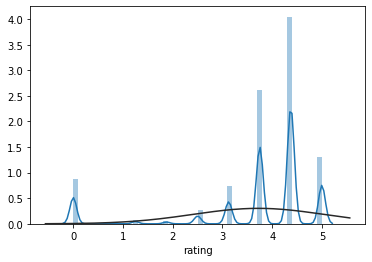

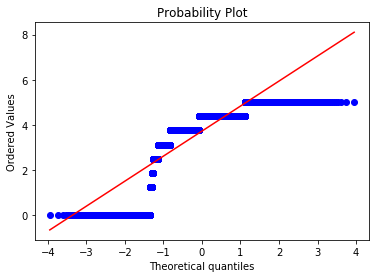

In [82]:
create_hist_prob_plot(data['rating'])

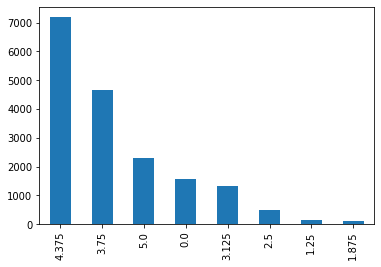

In [84]:
data['rating'].value_counts().plot.bar()
plt.show()

Um grande número de avaliações 4.375. Aparentemente algum erro!

### fat

In [85]:
data['fat'].describe().round(decimals=2).drop('count')

mean        373.50
std       21668.02
min           0.00
25%           9.00
50%          18.00
75%          35.00
max     1722763.00
Name: fat, dtype: float64

In [86]:
skew_kurt('fat')

Skewness: 74.252119
Kurtosis: 5747.229472


**Skewness** é o grau de distorção da curva simétrica ou da distribuição normal. Mede a falta de simetria na distribuição dos dados, diferenciando valores extremos. Uma distribuição simétrica terá skewness 0.

**Kurtosis** mostra tudo sobre a calda da distribuição. É usado para descrever os valores extremos, sendo na verdade a medida de outliers existentes na distribuição.

Percebemos um valor para o Kurtosis muito alto (High Kurtosis), indicando que temos muitos outliers. Vamos ajustá-los e também preencher os valores faltantes com a média, utilizando a técnica de **IQR Score**: 

In [87]:
# preenchendo valores faltantes e outliers com mediana
fillna_outlier_median('fat')

mean    19.82
std     14.87
min      0.00
25%     11.00
50%     17.00
75%     24.00
max     74.00
Name: fat, dtype: float64

In [88]:
skew_kurt('fat')

Skewness: 1.333320
Kurtosis: 1.859364


In [89]:
show_filling_factor(data)

,variable,missing values,filling factor (%)
0,desc,5858,67.026905
1,protein,3708,79.128673
2,sodium,3684,79.263762
3,calories,3683,79.269391
4,directions,0,100.000000
5,fat,0,100.000000
6,date,0,100.000000
7,categories,0,100.000000
8,rating,0,100.000000
9,title,0,100.000000


Apresentando a distribuição da variável **fat** e gerando um gráfico de probabilidade dos dados em relação aos quantis de uma distribuição normal:

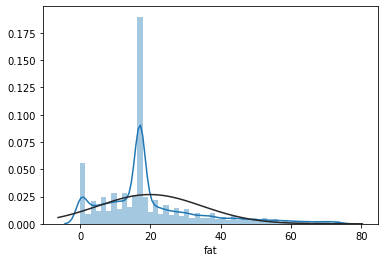

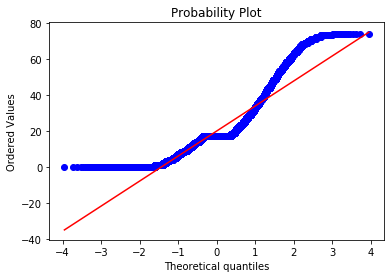

In [90]:
create_hist_prob_plot(data['fat'])

Plotando um boxplot para visualizar a posição, simetria, dispersão e valores discrepantes dos dados da feature **fat**:

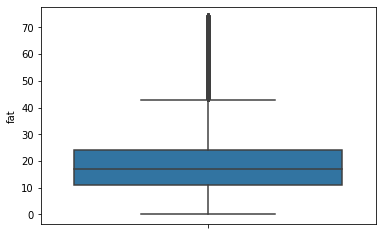

In [91]:
sns.boxplot(y=data['fat'])
plt.show()

### protein

In [92]:
data['protein'].describe().round(decimals=2).drop('count')

mean        94.60
std       3562.82
min          0.00
25%          3.00
50%          9.00
75%         29.00
max     236489.00
Name: protein, dtype: float64

In [93]:
skew_kurt('protein')

Skewness: 55.047617
Kurtosis: 3177.812071


A feature **protein** também possui muitos valores extremos. Vamos tratá-los junto com os valores faltantes assim como foi feito com fat.

In [94]:
# preenchendo valores faltantes e outliers com mediana
fillna_outlier_median('protein')

mean    13.30
std     14.34
min      0.00
25%      5.00
50%      8.00
75%     16.00
max     68.00
Name: protein, dtype: float64

In [95]:
skew_kurt('protein')

Skewness: 1.777203
Kurtosis: 2.487228


In [96]:
show_filling_factor(data)

,variable,missing values,filling factor (%)
0,desc,5858,67.026905
1,sodium,3684,79.263762
2,calories,3683,79.269391
3,directions,0,100.000000
4,fat,0,100.000000
5,date,0,100.000000
6,categories,0,100.000000
7,protein,0,100.000000
8,rating,0,100.000000
9,title,0,100.000000


Visualizando a distribuição de **protein**

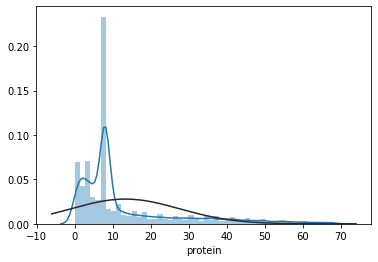

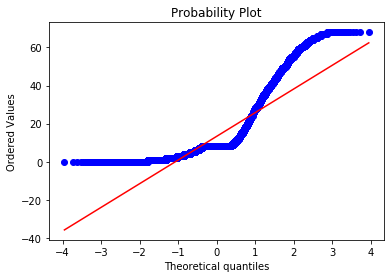

In [97]:
create_hist_prob_plot(data['protein'])

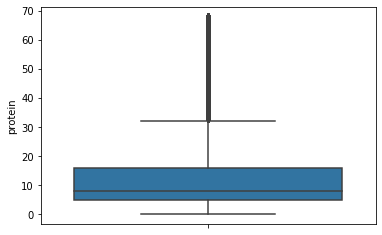

In [98]:
sns.boxplot(y=data['protein'])
plt.show()

### calories

In [99]:
data['calories'].describe().round(decimals=2).drop('count')

mean        6808.42
std       380315.15
min            0.00
25%          208.00
50%          351.00
75%          605.00
max     30111218.00
Name: calories, dtype: float64

In [100]:
skew_kurt('calories')

Skewness: 73.236272
Kurtosis: 5635.426321


Vamos resolver os valores faltantes e outliers de **calories** da mesma forma que os anteriores.

In [101]:
# preenchendo valores faltantes e outliers com mediana
fillna_outlier_median('calories')

mean     377.61
std      225.54
min        0.00
25%      242.00
50%      327.00
75%      460.00
max     1200.00
Name: calories, dtype: float64

In [102]:
skew_kurt('calories')

Skewness: 1.246337
Kurtosis: 1.556509


In [103]:
show_filling_factor(data)

,variable,missing values,filling factor (%)
0,desc,5858,67.026905
1,sodium,3684,79.263762
2,directions,0,100.000000
3,fat,0,100.000000
4,date,0,100.000000
5,categories,0,100.000000
6,calories,0,100.000000
7,protein,0,100.000000
8,rating,0,100.000000
9,title,0,100.000000


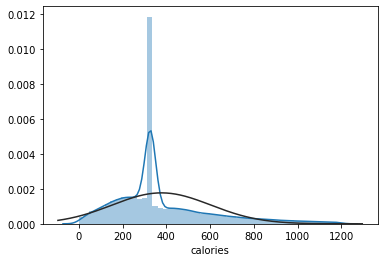

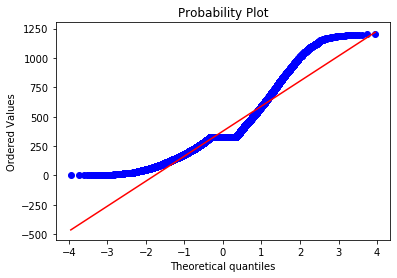

In [104]:
create_hist_prob_plot(data['calories'])

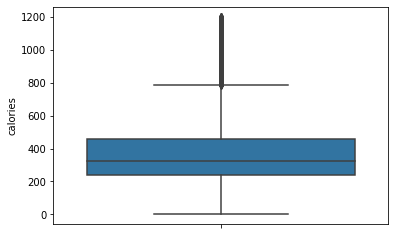

In [105]:
sns.boxplot(y=data['calories'])
plt.show()

### sodium

In [106]:
data['sodium'].describe().round(decimals=2).drop('count')

mean        6758.43
std       353561.36
min            0.00
25%           92.00
50%          310.00
75%          740.00
max     27675110.00
Name: sodium, dtype: float64

In [107]:
skew_kurt('sodium')

Skewness: 71.340269
Kurtosis: 5396.853017


In [108]:
# preenchendo valores faltantes e outliers com mediana
fillna_outlier_median('sodium')

mean     368.81
std      352.50
min        0.00
25%      137.00
50%      268.00
75%      462.00
max     1712.00
Name: sodium, dtype: float64

In [109]:
skew_kurt('sodium')

Skewness: 1.609521
Kurtosis: 2.240760


In [110]:
show_filling_factor(data)

,variable,missing values,filling factor (%)
0,desc,5858,67.026905
1,directions,0,100.000000
2,fat,0,100.000000
3,date,0,100.000000
4,categories,0,100.000000
5,calories,0,100.000000
6,protein,0,100.000000
7,rating,0,100.000000
8,title,0,100.000000
9,ingredients,0,100.000000


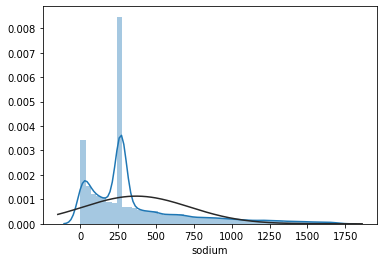

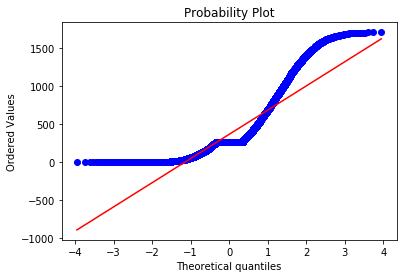

In [111]:
create_hist_prob_plot(data['sodium'])

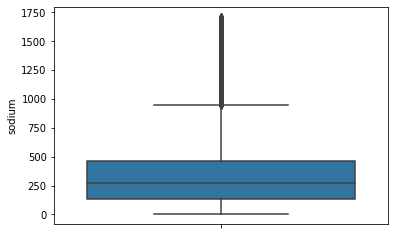

In [112]:
sns.boxplot(y=data['sodium'])
plt.show()

### categories

Verificando as 10 categorias mais utilizadas:

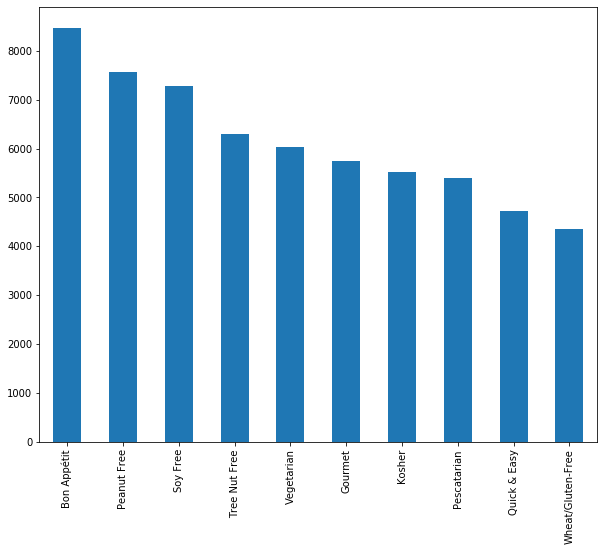

Em um total de  673 categorias


In [119]:
# Quantas vezes cada categoria aparece
cat = count_sublist_values(data, 'categories')

# plot top 10 categorias usadas
plt.figure(figsize=(10,8))
cat.value_counts().nlargest(10).plot.bar(5)
plt.show()

unique_cat = sublist_uniques(data, 'categories')
print('Em um total de  \u001b[1m{} categorias'.format(len(unique_cat)))

#### 1) A categorias pertencem as comidas mais calóricas?
* Foram selecionadas as 5 receitas mais caloricas para a análise

In [120]:
# 5 receitas mais caloricas e suas categorias
cal_receipts = data.nlargest(5, columns='calories')
cal_receipts_unique_cat = count_sublist_values(cal_receipts, 'categories')
cal_receipts_unique_cat.value_counts()

Bon Appétit          4
Sauté                2
Pescatarian          2
Peanut Free          2
Walnut               2
Herb                 2
Soy Free             2
Dinner               2
Bake                 2
Valentine's Day      1
Shrimp               1
Lamb                 1
Dairy Free           1
Nut                  1
Bread                1
Lobster              1
Dessert              1
Lemon                1
Pasta                1
Potato               1
Seafood              1
Tomato               1
Low Fat              1
Ice Cream Machine    1
High Fiber           1
Chill                1
Mussel               1
Summer               1
Egg                  1
Cheese               1
Anniversary          1
Low Cal              1
Pumpkin              1
Noodle               1
Tree Nut Free        1
Carrot               1
White Wine           1
Kosher               1
Fruit                1
Low Carb             1
Dairy                1
Citrus               1
Squid                1
Basil      

### ingredients

In [ ]:
data.reset_index(drop=True, inplace=True)

# extraindo ingredientes de cada registro
recipe_ingredients = [] # armazena os ingredientes de cada receita
ingredients_list = [] # lista com todos ingredientes presentes nos dados

for i in range(len(data['ingredients'])):
    recipe_ingredients.append([])
    
    for j in range(len(data['ingredients'][i])):
        tokenized_ingredients = nltk.word_tokenize(data['ingredients'][i][j])
        
        # lista de tags https://www.ling.upenn.edu/courses/Fall_2003/ling001/penn_treebank_pos.html    
        tagged_ingredients = nltk.pos_tag(tokenized_ingredients)         
        tagged_ingredients = [k for k in tagged_ingredients if (k[1] == 'NN' or k[1] == 'NNS') and (re.match('[^0-9]', k[0]))]
        tagged_ingredients = tagged_ingredients[-1:]
        
        if len(tagged_ingredients) != 0:
            recipe_ingredients[i].append(tagged_ingredients[0][0]) # adicionando apenas o token
            ingredients_list.append(tagged_ingredients[0][0])

In [ ]:
# Quais os top 10 ingredientes contidos nas receitas mais calóricas?
ingredients = pd.Series(recipe_ingredients, name='recipe_ingredients')
data = pd.concat([data, ingredients], axis=1)
data.head()

In [ ]:
cal_receipts = data.nlargest(5, columns='calories')
cal_receipts_unique_ing = count_sublist_values(cal_receipts, 'recipe_ingredients')
cal_receipts_unique_ing.value_counts().nlargest(10, keep='all').plot.bar() 
plt.show()

Era de se esperar que sal e açucar fossem os ingredientes mais utilizados. 

In [ ]:
# Considerando-se as categorias das top 100 receitas em avaliação, quantas receitas há atualmente no site https://www.epicurious.com para cada categoria
# usando as ultimas de acordo com a data
top_100_rating_recipe = data.sort_values('date', ascending=False).nlargest(100, columns='rating')
top_100_rating_recipe

In [ ]:
top_100_cat_recipe = count_sublist_values(top_100_rating_recipe, 'categories')

# top 100 categorias das top 100 receitas em avaliação
top_100_cat_recipe.value_counts().nlargest(100).index

In [ ]:
cat100 = top_100_cat_recipe.value_counts().nlargest(100).index
for cat in cat100:
    count = 0
    print(cat)
    for i in data.index:
        val = data.loc[i,'categories']
        if cat in val:
            count+=1
    print('{} receitas.\n'.format(count))

In [ ]:
# Alguma característica presente nos dados determina a alta nota de uma receita?
dict_plt = {0:'calories',1:'protein',2:'fat',3:'sodium'}

sns.set(font_scale=.7)

fig, ax = plt.subplots(1,4, figsize=(20,3))

for i in range(4):
    sns.barplot(x='rating',y=dict_plt[i], data=data, ax=ax[i], errwidth=1)
    ax[i].set_title('rating por {}'.format(dict_plt[i]), size=15)
    ax[i].set_ylabel('')